=== Adopted Problem: 1D Constant-Velocity ===
dt=0.1, state=[pos, vel], measurement=pos only
F=
 [[1.  0.1]
 [0.  1. ]]
H=
 [[1. 0.]]
Q_true = (q_scale^2) I, q_scale=0.1
R_true = (r_scale^2) I, r_scale=1.0
diag(Q_true) = [0.01 0.01]
diag(R_true) = [1.]
Assumed KF uses larger covariances: gamma_Q=10.0, gamma_R=5.0
diag(Q_assumed) = [0.09999999 0.09999999]
diag(R_assumed) = [5.]

Epoch 01 | Train MSE (KN): 1.402822 | Test MSE (KN): 0.304952 | Test MSE (KF assumed): 0.285900
Epoch 02 | Train MSE (KN): 0.302743 | Test MSE (KN): 0.292964 | Test MSE (KF assumed): 0.285900
Epoch 03 | Train MSE (KN): 0.296462 | Test MSE (KN): 0.288965 | Test MSE (KF assumed): 0.285900
Epoch 04 | Train MSE (KN): 0.291116 | Test MSE (KN): 0.282613 | Test MSE (KF assumed): 0.285900
Epoch 05 | Train MSE (KN): 0.284283 | Test MSE (KN): 0.276227 | Test MSE (KF assumed): 0.285900
Epoch 06 | Train MSE (KN): 0.278067 | Test MSE (KN): 0.271560 | Test MSE (KF assumed): 0.285900
Epoch 07 | Train MSE (KN): 0.274520 | Test 

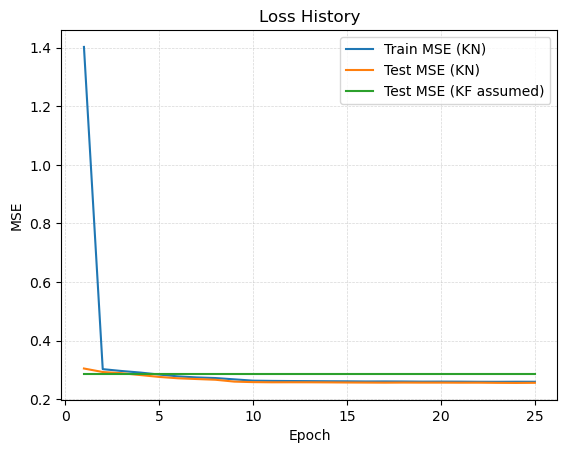


===== Final Comparison on Test Set =====
KalmanNet (learned K)        MSE: 2.561151e-01 | RMSE: 5.060782e-01
Kalman Filter (assumed Q/R)  MSE: 2.858995e-01 | RMSE: 5.346958e-01


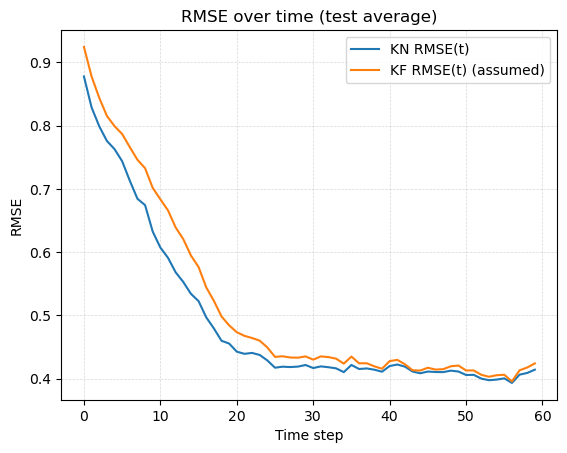

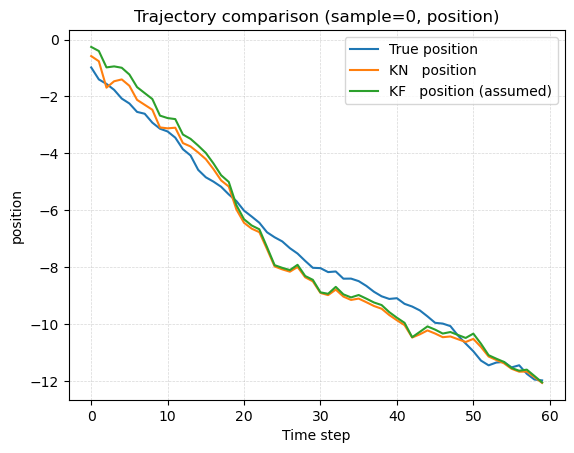

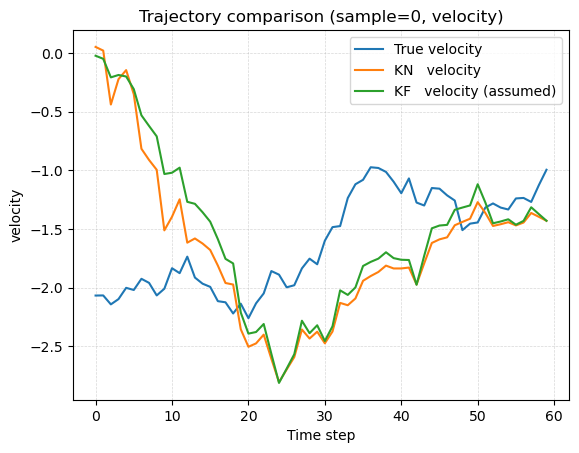

In [1]:
"""
KalmanNet (Linear) on a simple 1D Constant-Velocity model
State: x_t = [position, velocity]^T
Measurement: y_t = position

Ground truth data generation uses Q_true, R_true.
Baseline Kalman Filter assumes larger covariances: Q_assumed, R_assumed.

Outputs:
- Loss histories: train MSE (KN), test MSE (KN), test MSE (KF assumed)
- Final plots: loss history, RMSE over time, sample trajectory comparisons
"""

import math
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from typing import Optional, Tuple, Dict, List


# -------------------------
# Utils
# -------------------------
def set_seed(seed: int = 0) -> None:
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)


def sample_linear_sequences(
    num_seq: int,
    T: int,
    F: torch.Tensor,
    H: torch.Tensor,
    Q: torch.Tensor,
    R: torch.Tensor,
    x0_cov: float = 1.0,
    device: str = "cpu",
) -> Tuple[torch.Tensor, torch.Tensor]:
    """
    x_{t+1} = F x_t + w_t,   w_t ~ N(0,Q)
    y_t     = H x_t + v_t,   v_t ~ N(0,R)

    Returns:
      x: [N,T,n], y: [N,T,m]
    """
    n = F.shape[0]
    m = H.shape[0]

    LQ = torch.linalg.cholesky(Q)
    LR = torch.linalg.cholesky(R)

    x = torch.zeros(num_seq, T, n, device=device)
    y = torch.zeros(num_seq, T, m, device=device)

    # initial state
    x[:, 0, :] = torch.randn(num_seq, n, device=device) * math.sqrt(x0_cov)

    for t in range(T):
        # measurement
        v = torch.randn(num_seq, m, device=device) @ LR.T
        y[:, t, :] = x[:, t, :] @ H.T + v

        # transition
        if t < T - 1:
            w = torch.randn(num_seq, n, device=device) @ LQ.T
            x[:, t + 1, :] = x[:, t, :] @ F.T + w

    return x, y


# -------------------------
# Dataset
# -------------------------
class SeqDataset(torch.utils.data.Dataset):
    def __init__(self, x: torch.Tensor, y: torch.Tensor):
        self.x = x
        self.y = y

    def __len__(self) -> int:
        return self.x.shape[0]

    def __getitem__(self, idx: int):
        return self.x[idx], self.y[idx]


# -------------------------
# Baseline: Batch Kalman Filter (uses assumed Q,R)
# -------------------------
@torch.no_grad()
def batch_kalman_filter(
    y: torch.Tensor,   # [B,T,m]
    F: torch.Tensor,
    H: torch.Tensor,
    Q: torch.Tensor,
    R: torch.Tensor,
    x0: Optional[torch.Tensor] = None,
    P0: Optional[torch.Tensor] = None,
) -> torch.Tensor:
    """
    Returns xhat: [B,T,n]
    """
    device = y.device
    B, T, _ = y.shape
    n = F.shape[0]

    x_hat = torch.zeros(B, n, device=device) if x0 is None else x0.clone()
    P = torch.eye(n, device=device).unsqueeze(0).repeat(B, 1, 1) if P0 is None else P0.clone()
    I = torch.eye(n, device=device).unsqueeze(0)

    xhats = []
    for t in range(T):
        # Predict
        x_pred = x_hat @ F.T
        P_pred = F.unsqueeze(0) @ P @ F.T.unsqueeze(0) + Q.unsqueeze(0)

        # Innovation
        y_pred = x_pred @ H.T
        innov = y[:, t, :] - y_pred  # [B,m]

        S = H.unsqueeze(0) @ P_pred @ H.T.unsqueeze(0) + R.unsqueeze(0)  # [B,m,m]
        K = P_pred @ H.T.unsqueeze(0) @ torch.linalg.inv(S)              # [B,n,m]

        # Update
        x_hat = x_pred + torch.bmm(K, innov.unsqueeze(-1)).squeeze(-1)
        P = (I - K @ H.unsqueeze(0)) @ P_pred

        xhats.append(x_hat)

    return torch.stack(xhats, dim=1)


# -------------------------
# KalmanNet (learn K_t with GRU)
# -------------------------
class SimpleKalmanNet(nn.Module):
    """
    Simplified KalmanNet:
    - Keep KF structure
    - Learn time-varying gain K_t from innovation only via GRUCell
    - Output K_t in R^{n x m}
    """

    def __init__(self, n: int, m: int, hidden_size: int = 32):
        super().__init__()
        self.n = n
        self.m = m
        self.gru = nn.GRUCell(input_size=m, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, n * m)

        # stable init
        nn.init.zeros_(self.fc.weight)
        nn.init.zeros_(self.fc.bias)

    def forward(
        self,
        y: torch.Tensor,  # [B,T,m]
        F: torch.Tensor,
        H: torch.Tensor,
        x0: Optional[torch.Tensor] = None,
    ) -> torch.Tensor:
        device = y.device
        B, T, _ = y.shape
        n, m = self.n, self.m

        x_hat = torch.zeros(B, n, device=device) if x0 is None else x0
        h = torch.zeros(B, self.gru.hidden_size, device=device)

        xhats = []
        for t in range(T):
            # Predict
            x_pred = x_hat @ F.T
            y_pred = x_pred @ H.T
            innov = y[:, t, :] - y_pred  # [B,m]

            # Learn K_t
            h = self.gru(innov, h)
            K = self.fc(h).view(B, n, m)  # [B,n,m]

            # Update
            x_hat = x_pred + torch.bmm(K, innov.unsqueeze(-1)).squeeze(-1)
            xhats.append(x_hat)

        return torch.stack(xhats, dim=1)


# -------------------------
# Plots (after training)
# -------------------------
def plot_loss_history(
    train_hist: List[float],
    test_hist_kn: List[float],
    test_hist_kf: Optional[List[float]] = None,
    savepath: Optional[str] = None,
) -> None:
    epochs = np.arange(1, len(train_hist) + 1)

    plt.figure()
    plt.plot(epochs, train_hist, label="Train MSE (KN)")
    plt.plot(epochs, test_hist_kn, label="Test MSE (KN)")
    if test_hist_kf is not None:
        plt.plot(epochs, test_hist_kf, label="Test MSE (KF assumed)")
    plt.xlabel("Epoch")
    plt.ylabel("MSE")
    plt.title("Loss History")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    if savepath:
        plt.savefig(savepath, dpi=200, bbox_inches="tight")
    plt.show()


@torch.no_grad()
def rmse_over_time(xhat: torch.Tensor, x_true: torch.Tensor) -> torch.Tensor:
    """
    xhat, x_true: [N,T,n] -> rmse_t: [T] averaged over N and n
    """
    mse_t = ((xhat - x_true) ** 2).mean(dim=(0, 2))
    return torch.sqrt(mse_t + 1e-12)


def compare_final_model(
    model: nn.Module,
    F: torch.Tensor,
    H: torch.Tensor,
    Q_assumed: torch.Tensor,
    R_assumed: torch.Tensor,
    x_test: torch.Tensor,
    y_test: torch.Tensor,
    sample_idx: int = 0,
    save_prefix: Optional[str] = None,
) -> Dict[str, object]:
    """
    Compare final trained KalmanNet vs Kalman Filter (assumed Q/R).
    """
    device = next(model.parameters()).device
    x_test_d = x_test.to(device)
    y_test_d = y_test.to(device)
    F_d, H_d = F.to(device), H.to(device)
    Q_a, R_a = Q_assumed.to(device), R_assumed.to(device)

    model.eval()
    xhat_kn = model(y_test_d, F_d, H_d)
    kn_mse = torch.mean((xhat_kn - x_test_d) ** 2).item()
    kn_rmse = float(np.sqrt(kn_mse))

    xhat_kf = batch_kalman_filter(y_test_d, F_d, H_d, Q_a, R_a)
    kf_mse = torch.mean((xhat_kf - x_test_d) ** 2).item()
    kf_rmse = float(np.sqrt(kf_mse))

    print("\n===== Final Comparison on Test Set =====")
    print(f"KalmanNet (learned K)        MSE: {kn_mse:.6e} | RMSE: {kn_rmse:.6e}")
    print(f"Kalman Filter (assumed Q/R)  MSE: {kf_mse:.6e} | RMSE: {kf_rmse:.6e}")

    # RMSE over time plot
    rmse_kn_t = rmse_over_time(xhat_kn, x_test_d).detach().cpu().numpy()
    rmse_kf_t = rmse_over_time(xhat_kf, x_test_d).detach().cpu().numpy()
    t = np.arange(len(rmse_kn_t))

    plt.figure()
    plt.plot(t, rmse_kn_t, label="KN RMSE(t)")
    plt.plot(t, rmse_kf_t, label="KF RMSE(t) (assumed)")
    plt.xlabel("Time step")
    plt.ylabel("RMSE")
    plt.title("RMSE over time (test average)")
    plt.legend()
    plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
    if save_prefix:
        plt.savefig(f"{save_prefix}_rmse_over_time.png", dpi=200, bbox_inches="tight")
    plt.show()

    # Single sample trajectories (position and velocity)
    sample_idx = int(sample_idx)
    x_true_1 = x_test_d[sample_idx].detach().cpu().numpy()  # [T,2]
    x_kn_1 = xhat_kn[sample_idx].detach().cpu().numpy()
    x_kf_1 = xhat_kf[sample_idx].detach().cpu().numpy()

    labels = ["position", "velocity"]
    for i in range(2):
        plt.figure()
        plt.plot(t, x_true_1[:, i], label=f"True {labels[i]}")
        plt.plot(t, x_kn_1[:, i], label=f"KN   {labels[i]}")
        plt.plot(t, x_kf_1[:, i], label=f"KF   {labels[i]} (assumed)")
        plt.xlabel("Time step")
        plt.ylabel(labels[i])
        plt.title(f"Trajectory comparison (sample={sample_idx}, {labels[i]})")
        plt.legend()
        plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.5)
        if save_prefix:
            plt.savefig(f"{save_prefix}_traj_sample{sample_idx}_{labels[i]}.png", dpi=200, bbox_inches="tight")
        plt.show()

    return {
        "kn_mse": kn_mse,
        "kf_mse": kf_mse,
        "kn_rmse_t": rmse_kn_t,
        "kf_rmse_t": rmse_kf_t,
    }


# -------------------------
# Train / Eval
# -------------------------
def train_kalmannet():
    set_seed(0)
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # ----- Problem setup (your simplified matrices) -----
    dt = 0.1
    F = torch.tensor([[1.0, dt],
                      [0.0, 1.0]], device=device)  # State transition
    H = torch.tensor([[1.0, 0.0]], device=device)  # Observe position only

    # Ground-truth noise used to generate data (unknown to us)
    q_scale = 0.1  # Process noise std
    r_scale = 1.0  # Measurement noise std
    Q_true = (torch.eye(2, device=device) * (q_scale ** 2))
    R_true = (torch.eye(1, device=device) * (r_scale ** 2))

    # Assumed (larger) covariances used by baseline KF
    gamma_Q = 10.0
    gamma_R = 5.0
    Q_assumed = gamma_Q * Q_true
    R_assumed = gamma_R * R_true

    # Print adopted problem
    print("=== Adopted Problem: 1D Constant-Velocity ===")
    print(f"dt={dt}, state=[pos, vel], measurement=pos only")
    print("F=\n", F.detach().cpu().numpy())
    print("H=\n", H.detach().cpu().numpy())
    print(f"Q_true = (q_scale^2) I, q_scale={q_scale}")
    print(f"R_true = (r_scale^2) I, r_scale={r_scale}")
    print("diag(Q_true) =", torch.diag(Q_true).detach().cpu().numpy())
    print("diag(R_true) =", torch.diag(R_true).detach().cpu().numpy())
    print(f"Assumed KF uses larger covariances: gamma_Q={gamma_Q}, gamma_R={gamma_R}")
    print("diag(Q_assumed) =", torch.diag(Q_assumed).detach().cpu().numpy())
    print("diag(R_assumed) =", torch.diag(R_assumed).detach().cpu().numpy())
    print()

    # ----- Data -----
    T = 60
    N_train, N_test = 4000, 800
    x_train, y_train = sample_linear_sequences(N_train, T, F, H, Q_true, R_true, x0_cov=1.0, device=device)
    x_test, y_test = sample_linear_sequences(N_test, T, F, H, Q_true, R_true, x0_cov=1.0, device=device)

    train_loader = DataLoader(SeqDataset(x_train, y_train), batch_size=128, shuffle=True)
    test_loader = DataLoader(SeqDataset(x_test, y_test), batch_size=256, shuffle=False)

    # ----- Model -----
    model = SimpleKalmanNet(n=2, m=1, hidden_size=32).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = nn.MSELoss()

    # ----- Loss histories -----
    train_hist: List[float] = []
    test_hist_kn: List[float] = []
    test_hist_kf: List[float] = []

    num_epochs = 25
    for epoch in range(1, num_epochs + 1):
        model.train()
        total = 0.0

        for x_b, y_b in train_loader:
            opt.zero_grad()
            xhat = model(y_b, F, H)
            loss = loss_fn(xhat, x_b)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            opt.step()
            total += loss.item() * x_b.size(0)

        train_mse = total / len(train_loader.dataset)

        # Test (KN)
        model.eval()
        with torch.no_grad():
            tot = 0.0
            for x_b, y_b in test_loader:
                xhat = model(y_b, F, H)
                tot += loss_fn(xhat, x_b).item() * x_b.size(0)
            test_mse_kn = tot / len(test_loader.dataset)

            # Test (KF with assumed bigger Q/R)
            xhat_kf = batch_kalman_filter(y_test, F, H, Q_assumed, R_assumed)
            test_mse_kf = torch.mean((xhat_kf - x_test) ** 2).item()

        train_hist.append(train_mse)
        test_hist_kn.append(test_mse_kn)
        test_hist_kf.append(test_mse_kf)

        print(
            f"Epoch {epoch:02d} | "
            f"Train MSE (KN): {train_mse:.6f} | "
            f"Test MSE (KN): {test_mse_kn:.6f} | "
            f"Test MSE (KF assumed): {test_mse_kf:.6f}"
        )

    # ----- Plot and compare -----
    plot_loss_history(train_hist, test_hist_kn, test_hist_kf)
    compare_final_model(
        model=model,
        F=F,
        H=H,
        Q_assumed=Q_assumed,
        R_assumed=R_assumed,
        x_test=x_test,
        y_test=y_test,
        sample_idx=0,
        save_prefix=None,
    )

    history = {
        "train_mse_kn": np.array(train_hist),
        "test_mse_kn": np.array(test_hist_kn),
        "test_mse_kf_assumed": np.array(test_hist_kf),
        "gamma_Q": gamma_Q,
        "gamma_R": gamma_R,
        "dt": dt,
        "q_scale": q_scale,
        "r_scale": r_scale,
    }
    return model, (F, H, Q_true, R_true, Q_assumed, R_assumed), history, (x_test, y_test)


if __name__ == "__main__":
    train_kalmannet()
